# Fitting SVG signal

In this notebook I will take a random sample of points from the SVG smoothed signal (created in Sunspot Data Plotting) and see if the Gaussian process can (essentially) fill in the rest of the points.

For this I will be using the ***qusi-periodic kernel function***, given by:

$$ k_{i,j} = A^2 \exp{\left[-\frac{(x_i-x_j)^2}{2 l^2} - \Gamma^2 \sin^2{\left(\frac{\pi (x_i - x_j)}{P} \right)} \right]} + \sigma^2 \delta_{ij}$$

A list of kernel functions for PyMC3 can be found at https://docs.pymc.io/en/v3/api/gp/cov.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp

In [2]:
df = pd.read_csv('Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values
yerr = np.zeros(len(X)) 

In [3]:
rng = [np.random.RandomState(1), np.random.RandomState(2), np.random.RandomState(3)] # testing 3 different samples
training_indices = [rng[i].choice(np.arange(y.size), size=1000, replace=False) for i in range(len(rng))] 

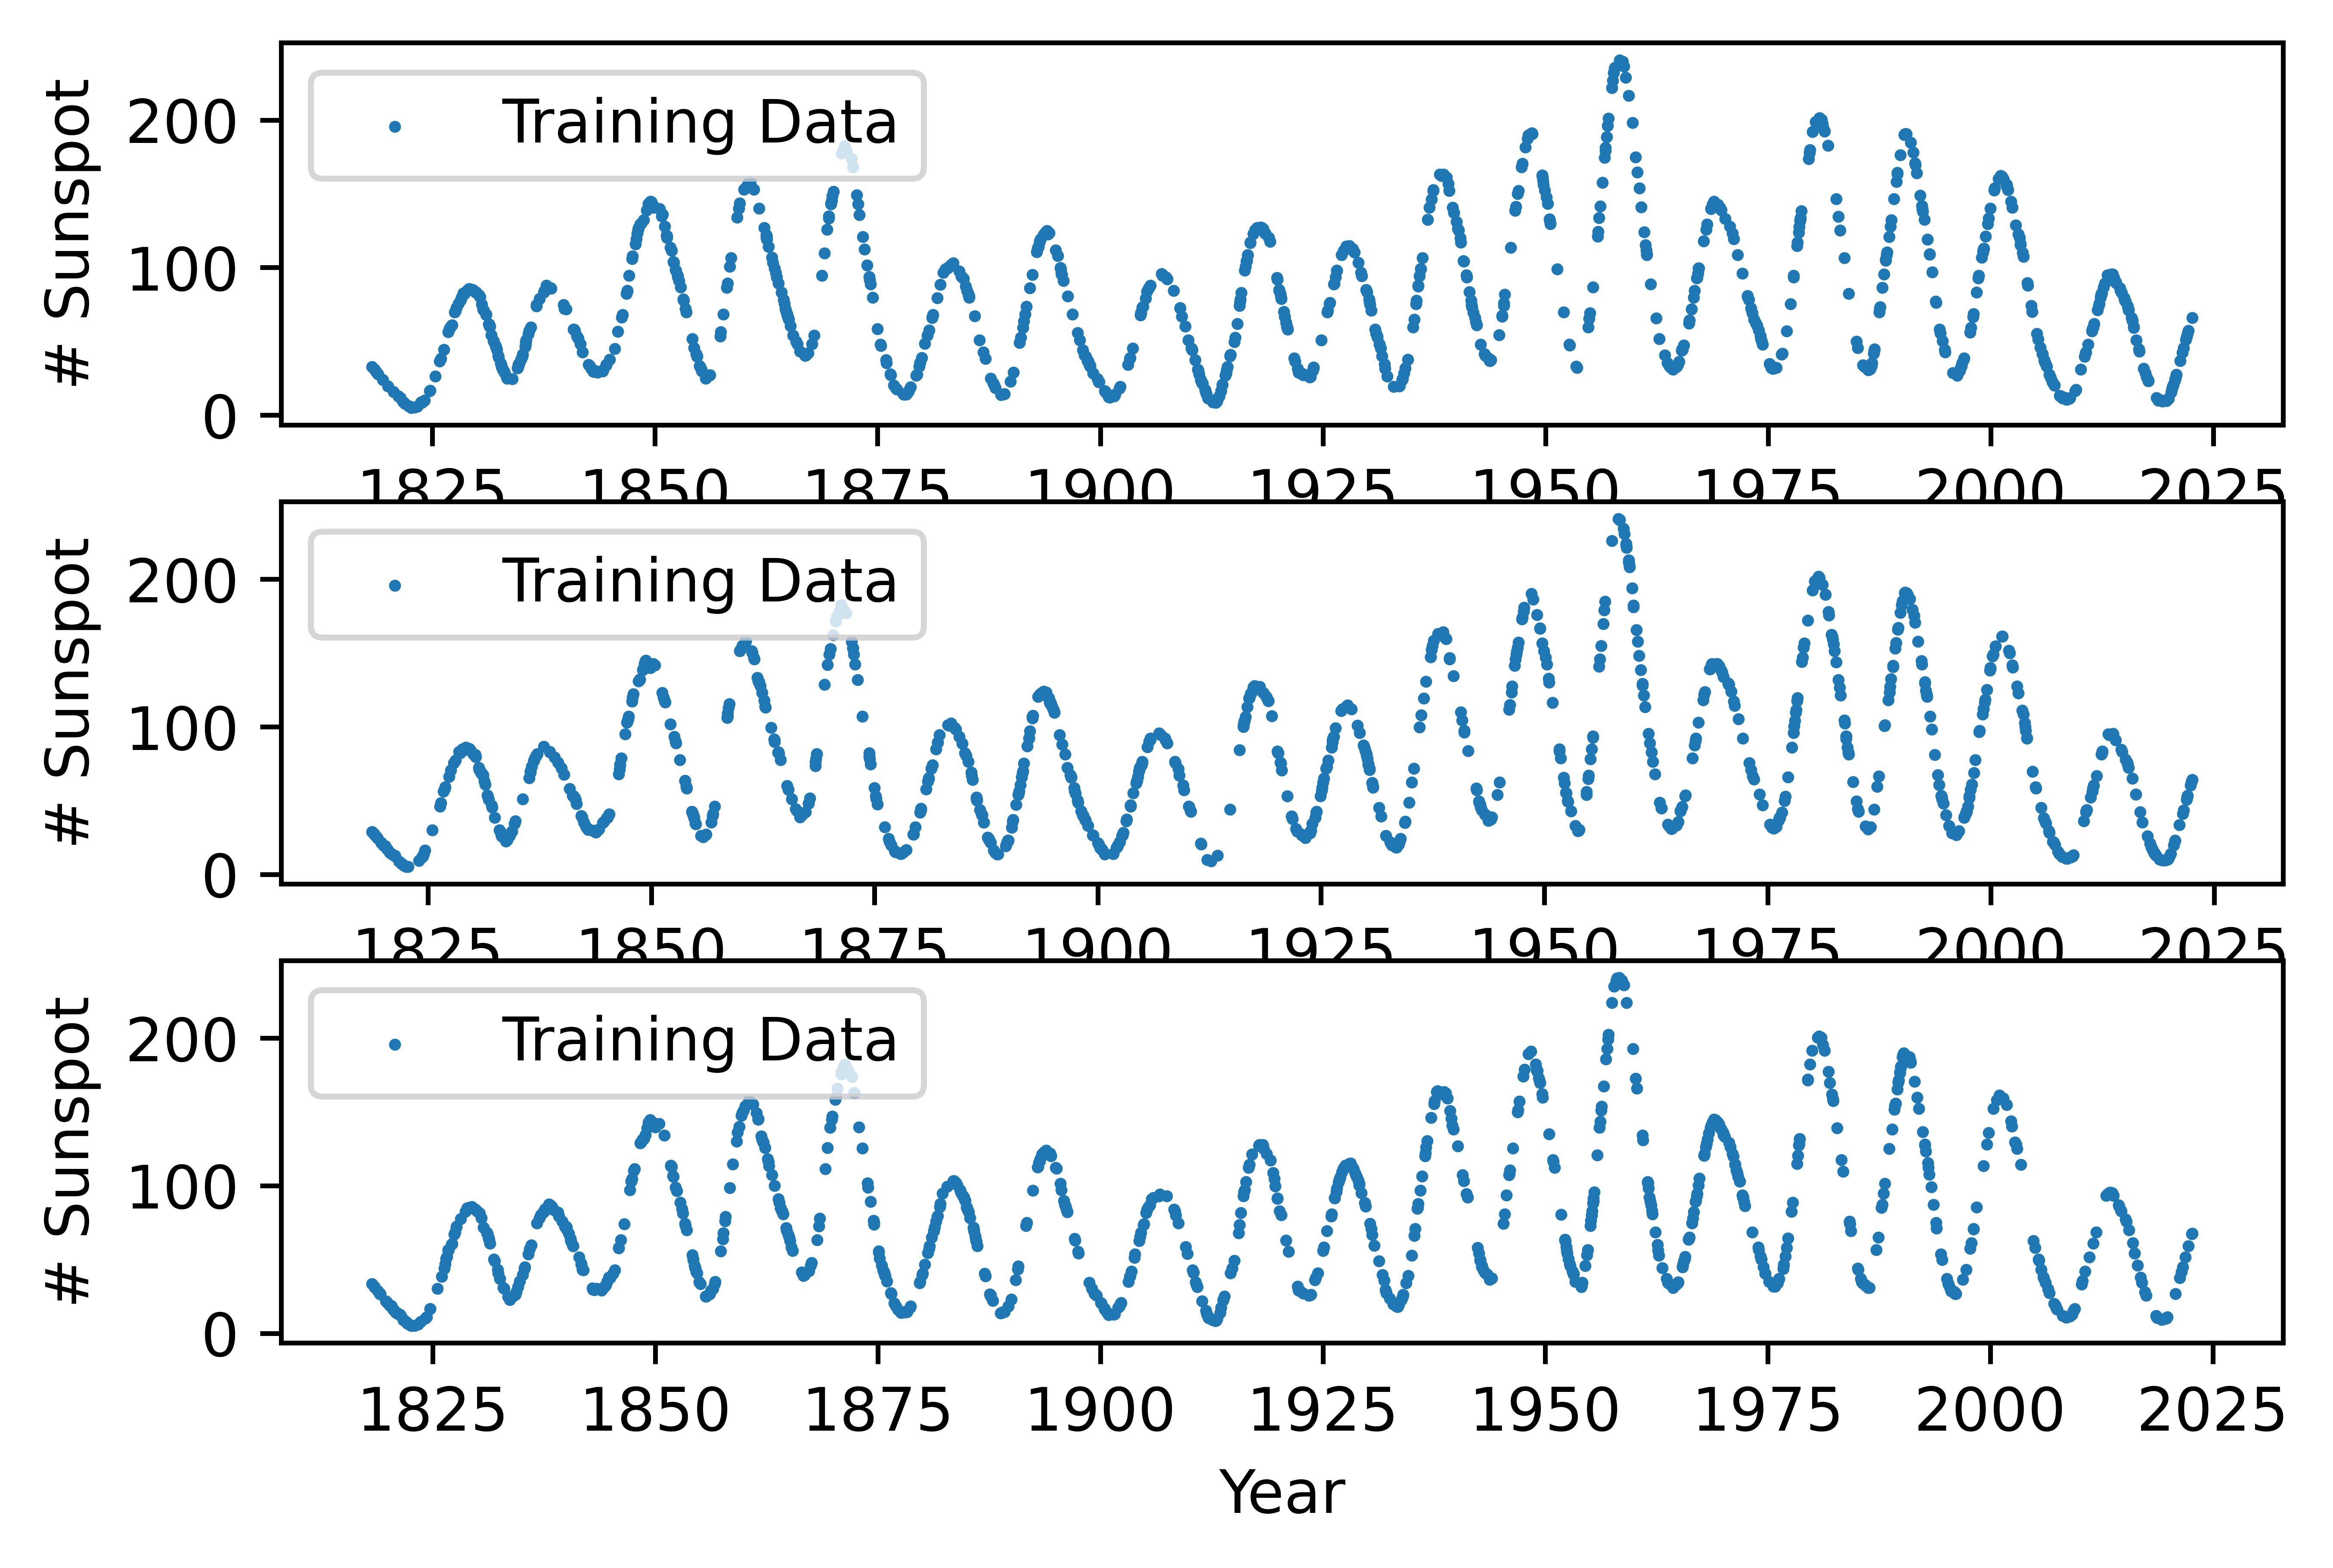

In [5]:
X_train = [X[training_indices[i]] for i in range(len(rng))] # x & y values of random indicies
y_train = [y[training_indices[i]] for i in range(len(rng))]

fig, ax = plt.subplots(len(rng), dpi=1000)
for i in range(len(rng)):
    ax[i].scatter(X_train[i], y_train[i], label='Training Data', s=1)
    ax[i].set_xlabel('Year')
    ax[i].set_ylabel("# Sunspot")
    ax[i].legend();

A simple implementation of our desired kernel is to use sklearn.gaussian_process.kernels.ExpSineSquared

https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared

In [7]:

for i in range(len(rng)):
    kernel = ExpSineSquared(length_scale=10, periodicity=11, length_scale_bounds=(1e-2, 1e2))
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50)
    gaussian_process.fit(X_train[i], y_train[i])
    gaussian_process.kernel_
    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    
    fig, ax = plt.subplots(dpi=200, figsize=(18,8))
    ax.plot(X, y, label=r"Sunspot Maxima", linestyle='dotted') 
    ax.scatter(X_train[i], y_train[i], label="Observations") # training data
    ax.plot(X, mean_prediction, label="Mean prediction") # gp prediction
    ax.fill_between(
        X.ravel(),
        mean_prediction - std_prediction, # 95% confidence interval
        mean_prediction + std_prediction,        label=r"95% confidence interval",
    )                                                
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel("# Sunspot");

KeyboardInterrupt: 

In [8]:
i = 0

In [46]:
with pm.Model() as model:
    
    cov = 10.0 * pm.gp.cov.Periodic(1, period=11.2, ls=1) # predefined covariance function
    cov *= pm.gp.cov.ExpQuad(1, ls=50.0)
    
    mu = pm.Normal('mu', 100, 50)
    const_func = pm.gp.mean.Constant(mu)
    
    gp = pm.gp.Marginal(cov_func=cov, mean_func=const_func)  # implementation of the sum of a GP prior and noise

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X_train[i], y=y_train[i], noise=1)

    mp = pm.find_MAP() # finds local maximimum 'a posteriori point' given a model

In [47]:
X_new = np.linspace(1820, 2055, 2000)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_posterior_predictive([mp], var_names=['y_pred'], samples=200)

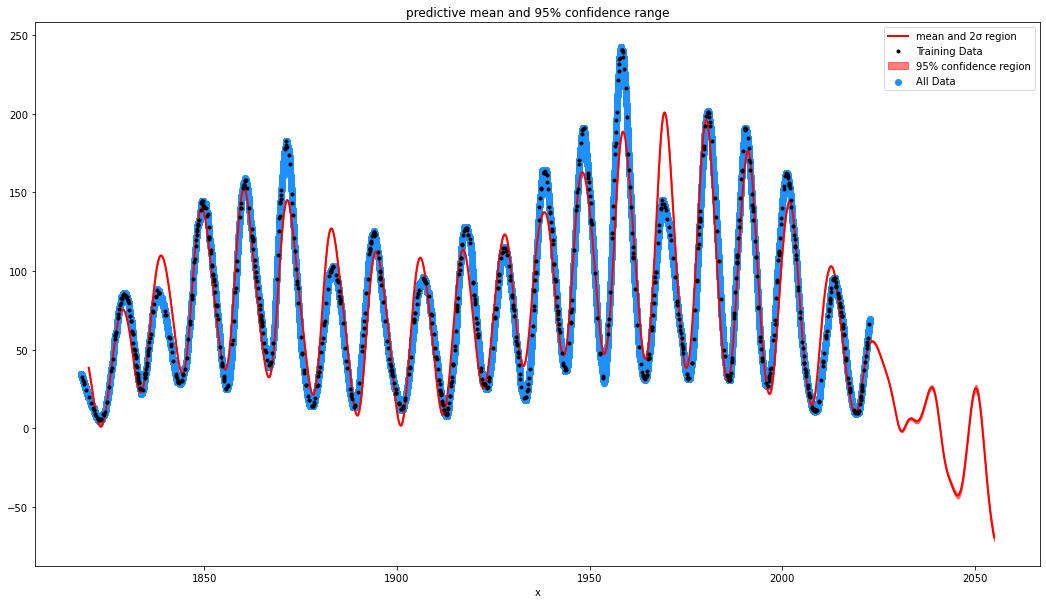

In [49]:
# predict
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var) # not true, but forces the plot to show greater uncertainty

# draw plot
fig = plt.figure(figsize=(18, 10))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, "r", lw=2, label="mean and 2σ region")
plt.fill_between(X_new.flatten(), mu - 1.96 * sd, mu + 1.96 * sd, color="r", alpha=0.5, label='95% confidence region')

# plot original data and true function
plt.plot(X_train[i], y_train[i], "ok", ms=3, alpha=1.0, label="Training Data")
plt.scatter(X, y, color="dodgerblue", label="All Data")

plt.xlabel("x")
plt.title("predictive mean and 95% confidence range")
plt.legend();

#### Comment on plot:

Here we have used a ***periodic kernel*** as opposed to the ***quasi-periodic kernel*** we want. We see that there are no uncertainty regions, which is a problem, and given the amoutn of data present the period doesn't seem to be a good enough fit. 